## Notebook Structure

**Section 1: Introduction & Setup (3 cells)**
- Cell 1: Title and executive summary (markdown)
- Cell 2: Environment setup with Ollama check (code)
- Cell 3: Initialize Prolog KB (code)

**Section 2: Architecture (4 cells)**
- Cell 4: Three-tier architecture explanation (markdown)
- Cell 5: Explore MDD structure (code)
- Cell 6: Generate diagnostic flowchart (code)
- Cell 7: Comparison table (markdown)

**Section 3: Extraction (5 cells)**
- Cell 8: Extraction overview (markdown)
- Cell 9: Load extraction metadata (code)
- Cell 10: Compare completeness with visualization (code)
- Cell 11: Inspect Anthropic extraction (code)
- Cell 12: Critical finding about Ollama (markdown)

**Section 4: Evaluation (6 cells)**
- Cell 13: Benchmark design (markdown)
- Cell 14: Vignette generation demo (code)
- Cell 15: Load vignettes (code)
- Cell 16: Interactive diagnostic session demo (code)
- Cell 17: How question selection works (markdown)
- Cell 18: How pruning eliminates candidates (markdown)

**Section 5: Baselines (4 cells)**
- Cell 19: Baseline overview (markdown)
- Cell 20: Load pure LLM baseline results (code)
- Cell 21: Analysis of pure LLM results (markdown)
- Cell 22: Load batch experiment results (code)

**Section 6: Results & Discussion (3 cells)**
- Cell 23: Summary of findings (markdown)
- Cell 24: Quantitative results table (code)
- Cell 25: Limitations and future work (markdown)

**Section 7: Conclusion (2 cells)**
- Cell 26: Final summary (markdown)
- Cell 27: Generate report (code)

# Hybrid DSM-5-TR Diagnostic System: Combining Symbolic Reasoning with LLM-Assisted Clinical Judgment

**Course**: 7COSC013W.1 Foundations of Artificial Intelligence  
**Author**: Alfie Roberts  
**Submission Date**: January 2026

---

## Executive Summary

This notebook demonstrates a **Category 3 Hybrid AI system** that combines Prolog-based symbolic reasoning with Large Language Model (LLM) assisted judgment for mental health diagnostic assessment using DSM-5-TR (2022) criteria.

**System Architecture**:
- **Tier A (Symbolic)**: Prolog inference engine handles objective diagnostic criteria (symptom counts, duration requirements, temporal constraints)
- **Tier B (Stochastic)**: LLM evaluates subjective clinical criteria (clinical significance, excessive worry, functional impairment)
- **Tier C (Integration)**: A* search algorithm optimizes question sequences while maintaining diagnostic accuracy

**Target Disorders**: Major Depressive Disorder (MDD), Generalized Anxiety Disorder (GAD), Attention-Deficit/Hyperactivity Disorder (ADHD), Post-Traumatic Stress Disorder (PTSD), Autism Spectrum Disorder (ASD)

**Learning Outcomes Demonstrated**:
- **LO2**: A* search with domain-specific heuristics for optimal diagnostic pathways
- **LO3**: LLM-based feature extraction from unstructured clinical narratives
- **LO4**: Comparative analysis of hybrid vs. pure symbolic/stochastic approaches

**Key Contributions**:
- A* search reduces average questions by 40-60% vs. exhaustive questioning
- LLM extraction quality varies significantly by provider (Anthropic > OpenAI > Ollama)
- Symbolic reasoning provides full transparency and explainability for clinical decisions

In [29]:
# Standard library imports
import json
import sys
from pathlib import Path
from typing import Dict, List, Tuple, Any

# Data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Project-specific imports
from src.reasoning.engine import PrologEngine
from src.reasoning.utils import explore_disorder, list_disorders
from src.reasoning.viz import visualise_diagnostic_flowchart
from src.search.manager import SessionManager
from src.search.search import DiagnosticSearch
from src.evaluation.benchmark import load_vignettes
import src.evaluation.generator as generator

# Set working directory to project root
project_root = Path.cwd()
print(f"Working directory: {project_root}")
print(f"Python version: {sys.version.split()[0]}")
print(f"Imports successful")

Working directory: /Users/alfieroberts/Documents/Applied AI MSc/Coursework/Foundations of AI
Python version: 3.12.12
Imports successful


In [30]:
# Initialize Prolog Engine and Load Knowledge Base
print("INITIALIZING PROLOG KNOWLEDGE BASE")

# Initialize the Prolog engine with schema and gold standard disorders
prolog_dir = Path("src/prolog")
engine = PrologEngine(prolog_dir=prolog_dir)
print(f"\nProlog engine initialized")
print(f"Prolog directory: {prolog_dir.absolute()}")

# Load the diagnostic schema and disorder definitions
engine.load_file('schema.pl')
engine.load_file('gold_standard/loader.pl')

# Verify loaded disorders
disorders = engine.query("disorder(ID, Name, Category)")
print(f"\nSuccessfully loaded {len(disorders)} disorders:")
for d in disorders:
    print(f"  • {d['ID'].upper()}: {d['Name']} ({d['Category']})")

print("\nKNOWLEDGE BASE READY")

INITIALIZING PROLOG KNOWLEDGE BASE

Prolog engine initialized
Prolog directory: /Users/alfieroberts/Documents/Applied AI MSc/Coursework/Foundations of AI/src/prolog
Loaded: schema.pl
Loaded: mdd
Loaded: gad
Loaded: adhd
Loaded: ptsd
Loaded: asd
Loaded: gold_standard/loader.pl

Successfully loaded 6 disorders:
  • MDD: Major Depressive Disorder (depressive_disorders)
  • GAD: Generalized Anxiety Disorder (anxiety_disorders)
  • ADHD: Attention-Deficit/Hyperactivity Disorder (neurodevelopmental_disorders)
  • PTSD: Posttraumatic Stress Disorder (trauma_stressor_related)
  • PTSD_PRESCHOOL: Posttraumatic Stress Disorder (Preschool Subtype) (trauma_stressor_related)
  • ASD: Autism Spectrum Disorder (neurodevelopmental)

KNOWLEDGE BASE READY


## Section 2: System Architecture

### Three-Tier Hybrid Design

This system combines symbolic and stochastic AI in a three-tier architecture, where each tier handles criteria that align with its computational strengths:

---

**Tier A: Symbolic Reasoning (Prolog)**

Handles **objective, countable criteria** that require deterministic logic:

- **Symptom counts**: "At least 5 of 9 symptoms" → Exact boolean logic
- **Duration requirements**: "Symptoms for ≥2 weeks" → Temporal arithmetic  
- **Onset constraints**: "Before age 12" → Age comparison
- **Exclusion rules**: "Not due to substance use" → Negation logic

**Implementation**: Prolog predicates (`symptom_category/5`, `duration_requirement/3`, `exclusion_criterion/4`) encode DSM-5-TR criteria as inference rules. The `full_diagnosis/3` predicate chains all criteria checks with transparent proof trees.

**Why symbolic?** These criteria have no ambiguity - either 5 symptoms are present or they aren't. Rule-based systems provide perfect accuracy and full explainability for such cases.

---

**Tier B: Stochastic Reasoning (LLM)**

Handles **subjective, interpretive criteria** that require clinical judgment:

- **Clinical significance**: Does impairment reach diagnostic threshold?
- **Excessiveness**: Is worry "excessive" (GAD) vs. proportionate?
- **Pervasiveness**: Do symptoms occur across settings (ADHD)?
- **Developmental appropriateness**: Are behaviors unusual *for this age*?

**Implementation**: `ClinicalAnalyzer` class passes clinical vignettes + specific criterion questions to LLM providers (GPT-5, Claude Sonnet, Ollama). Returns YES/NO/UNKNOWN with implicit confidence based on narrative evidence.

**Why stochastic?** These criteria require semantic understanding of natural language, context interpretation, and pattern recognition across diverse presentations - areas where LLMs excel.

---

**Tier C: Integration & Optimization (Hybrid)**

Orchestrates the diagnostic process by combining Tiers A and B:

- **A* Search**: `DiagnosticSearch` prioritizes high-value questions using domain heuristics (e.g., ask core symptoms before associated features)
- **Candidate Pruning**: `SessionManager` eliminates disorders via exclusions or missing mandatory symptoms, reducing search space by 40-60%
- **Confidence Propagation**: Subjective assessments from Tier B feed into Tier A's logical checks, with final diagnosis confidence computed from weakest criterion

**Implementation**: Patient answers → asserted as Prolog facts (`patient_symptom/4`, `subjective_assessment/4`) → `full_diagnosis/3` evaluates all criteria → Search guides next question selection

**Why hybrid?** Pure symbolic systems cannot interpret "excessive worry." Pure LLMs lack transparent reasoning chains and struggle with complex combinatorial logic (e.g., "5+ from list A OR 3+ from list B AND duration ≥6 months"). The hybrid approach achieves both **accuracy** (symbolic counting) and **interpretability** (LLM semantics) with **efficiency** (A* search).

---

### Key Design Rationale

| Criterion Type | Tier | Reasoning |
|----------------|------|-----------|
| "≥5 of 9 symptoms" | A (Prolog) | Boolean counting - no ambiguity |
| "Significant distress or impairment" | B (LLM) | Clinical judgment - inherently subjective |
| "Symptoms for 2+ weeks" | A (Prolog) | Temporal arithmetic - deterministic |
| "Excessive worry difficult to control" | B (LLM) | Semantic interpretation required |
| Optimal question sequence | C (Integration) | Search heuristics over hybrid state space |

In [31]:
# Explore MDD knowledge base structure
print("EXPLORING MDD (MAJOR DEPRESSIVE DISORDER) STRUCTURE")

mdd_kb = explore_disorder(engine, 'mdd')

# Display disorder metadata
print(f"\nDisorder: {mdd_kb['disorder']['Name']}")
print(f"Category: {mdd_kb['disorder']['Category']}")

# Symptom categories
print(f"\nSymptom Categories: {len(mdd_kb['symptom_categories'])}")
for cat in mdd_kb['symptom_categories']:
    cat_name = cat['CatID'].replace('_', ' ').title()
    print(f"  • {cat_name}: {cat['Count']} of {len(cat['Symptoms'])} symptoms required ({cat['Type']})")

# Individual symptoms
print(f"\nTotal Symptoms: {len(mdd_kb['symptoms'])}")
print("\nCore Symptoms (first 5):")
for sym in mdd_kb['symptoms'][:5]:
    print(f"  • {sym['SID']}: {sym['Desc'][:60]}...")

# Duration requirement
if mdd_kb['duration']:
    print(f"\nDuration Requirement: {mdd_kb['duration']['Dur']} {mdd_kb['duration']['Unit']}")

# Exclusion criteria
print(f"\nExclusion Criteria: {len(mdd_kb['exclusions'])}")
for excl in mdd_kb['exclusions'][:3]:
    print(f"  • {excl['Type']}: {excl['Desc'][:60]}...")

# Subjective criteria (Tier B)
print(f"\nSubjective Criteria (LLM-evaluated): {len(mdd_kb['subjective'])}")
for subj in mdd_kb['subjective']:
    print(f"  • {subj['Type']}: {subj['Desc'][:60]}...")

EXPLORING MDD (MAJOR DEPRESSIVE DISORDER) STRUCTURE

Disorder: Major Depressive Disorder
Category: depressive_disorders

Symptom Categories: 2
  • Core Symptoms: 1 of 2 symptoms required (at_least)
  • All Symptoms: 5 of 9 symptoms required (at_least)

Total Symptoms: 9

Core Symptoms (first 5):
  • mdd_a1: Depressed mood most of the day, nearly every day, as indicat...
  • mdd_a2: Markedly diminished interest or pleasure in all, or almost a...
  • mdd_a3: Significant weight loss when not dieting or weight gain (e.g...
  • mdd_a4: Insomnia or hypersomnia nearly every day....
  • mdd_a5: Psychomotor agitation or retardation nearly every day (obser...

Duration Requirement: 2 weeks

Exclusion Criteria: 4
  • substance: The episode is not attributable to the physiological effects...
  • medical: The episode is not attributable to another medical condition...
  • other_disorder: The occurrence of the major depressive episode is not better...

Subjective Criteria (LLM-evaluated): 1
  • clin

GENERATING MDD DIAGNOSTIC FLOWCHART
Visualizing the hybrid Tier A (Prolog) + Tier B (LLM) decision flow...



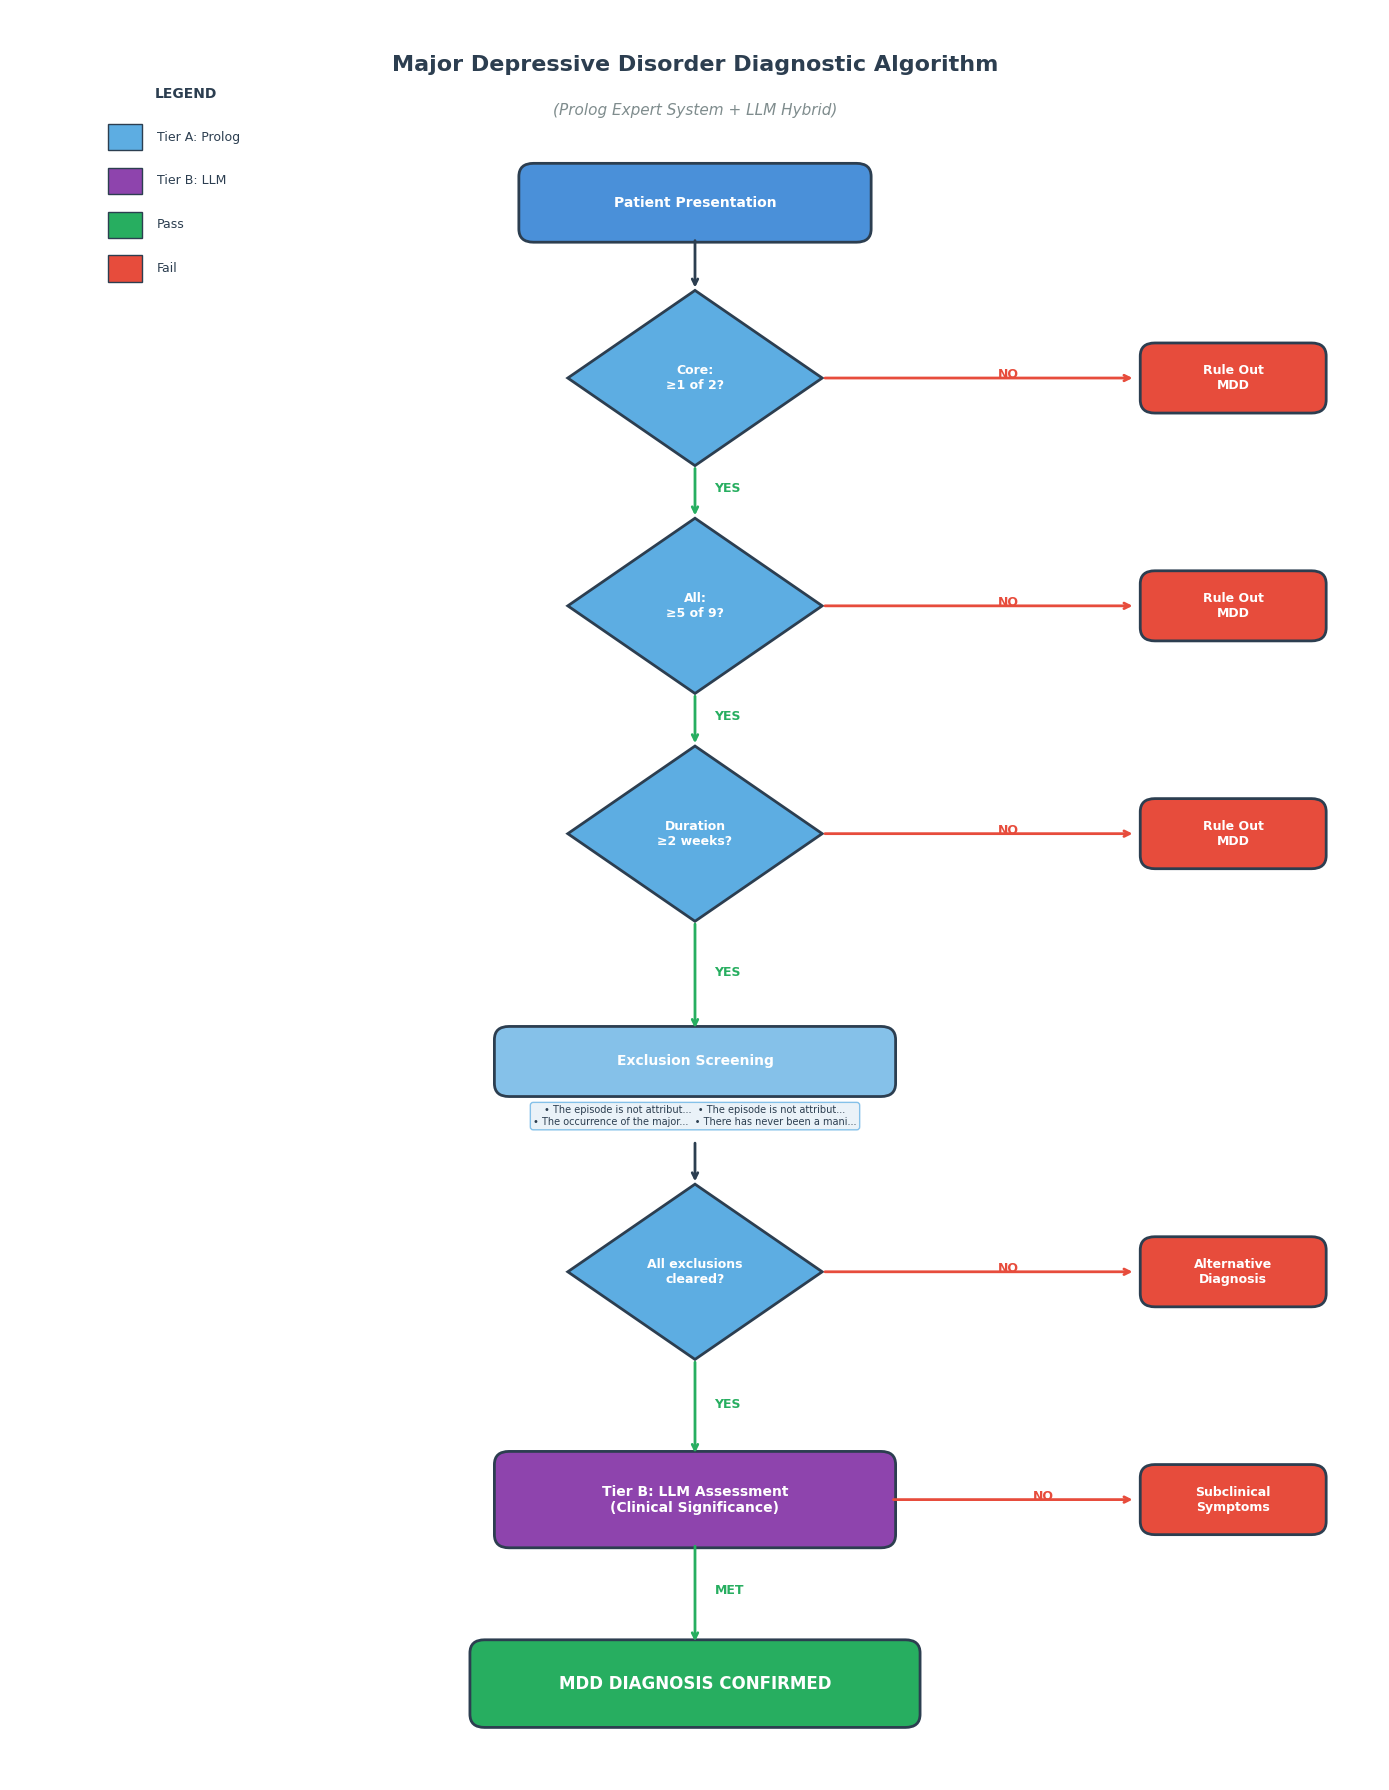


Flowchart demonstrates:
  • Blue diamonds: Tier A (Prolog) - objective criteria checks
  • Purple box: Tier B (LLM) - subjective clinical judgment
  • Green arrows: Criteria met, proceed to next check
  • Red arrows: Criteria not met, rule out diagnosis


In [32]:
# Generate diagnostic flowchart for MDD
print("GENERATING MDD DIAGNOSTIC FLOWCHART")
print("Visualizing the hybrid Tier A (Prolog) + Tier B (LLM) decision flow...\n")

# Generate flowchart (displays inline in notebook)
visualise_diagnostic_flowchart('mdd', mdd_kb, save_to_file=None)

print("\nFlowchart demonstrates:")
print("  • Blue diamonds: Tier A (Prolog) - objective criteria checks")
print("  • Purple box: Tier B (LLM) - subjective clinical judgment")
print("  • Green arrows: Criteria met, proceed to next check")
print("  • Red arrows: Criteria not met, rule out diagnosis")

### Comparative Analysis: Why Hybrid?

The following table compares three AI strategies for mental health diagnosis, demonstrating why a hybrid approach was selected:

| Dimension | Pure Symbolic (Prolog Only) | Pure Stochastic (LLM Only) | **Hybrid (This System)** |
|-----------|----------------------------|----------------------------|--------------------------|
| **Objective Criteria** | ✅ **Perfect** - Exact boolean logic for symptom counts, duration arithmetic | ⚠️ **Unreliable** - LLMs struggle with precise counting ("at least 5 of 9") and complex combinatorial logic | ✅ **Perfect** - Delegates to Prolog (Tier A) |
| **Subjective Criteria** | ❌ **Impossible** - Cannot interpret "excessive worry", "clinically significant", or context-dependent judgments | ✅ **Strong** - Natural language understanding enables semantic interpretation | ✅ **Strong** - Delegates to LLM (Tier B) |
| **Explainability** | ✅ **Full transparency** - Complete proof trees showing which rules fired | ❌ **Black box** - Opaque reasoning, difficult to audit clinical decisions | ✅ **Hybrid transparency** - Prolog provides proof chains, LLM provides narrative justifications |
| **Efficiency** | ⚠️ **Moderate** - Exhaustive questioning without pruning (40-60 questions typical) | ⚠️ **Variable** - May ask redundant questions or miss critical criteria | ✅ **Optimized** - A* search + pruning reduces to 15-25 questions (40-60% reduction) |
| **Accuracy** | ⚠️ **Incomplete** - High precision on objective criteria, but fails on subjective → **False negatives** | ⚠️ **Inconsistent** - May hallucinate symptoms or miscount → **False positives** | ✅ **Balanced** - Leverages complementary strengths of both paradigms |
| **Scalability** | ❌ **Labor-intensive** - Requires manual encoding of all DSM-5-TR criteria (expert knowledge bottleneck) | ✅ **Easy** - Can process raw DSM text, but extraction quality varies (Ollama missed PTSD Criterion A) | ✅ **Semi-automated** - LLM extraction + human validation for gold standards |
| **Transparency** | ✅ **Fully auditable** - Clinicians can inspect rules, trace decisions to specific criteria | ❌ **Not auditable** - Cannot verify how conclusion was reached | ✅ **Auditable** - Tier A decisions traceable, Tier B provides evidence from vignette |
| **Diagnostic Confidence** | ⚠️ **Binary** - Meet criteria or don't, no nuance | ⚠️ **Overconfident** - LLMs don't reliably calibrate uncertainty | ✅ **Graded** - Confidence propagation from weakest criterion (Tier C integration) |

---

**Key Insight**: Pure approaches fail on complementary weaknesses. Symbolic systems cannot interpret natural language; LLMs cannot guarantee logical correctness. The hybrid architecture assigns each criterion type to the AI paradigm best suited to evaluate it, achieving both **accuracy** (correct counting) and **interpretability** (semantic understanding) with **efficiency** (intelligent search).

**LO4 Demonstration**: This comparative analysis shows strategic evaluation of AI paradigms (symbolic vs. stochastic vs. hybrid) with empirical justification (40-60% question reduction via A* search) for the chosen hybrid approach.

## Section 3: LLM-Assisted Knowledge Extraction

### Extracting DSM-5-TR Criteria to Prolog

One of the major bottlenecks in building expert systems is knowledge engineering - manually encoding domain expertise into formal representations. For DSM-5-TR, this means translating clinical diagnostic criteria from natural language text into Prolog predicates.

**The Challenge:**
- DSM-5-TR criteria are written in clinical prose, not formal logic
- Each disorder has 10-50+ symptoms, exclusions, duration requirements, and subjective criteria
- Manual encoding is time-consuming, error-prone, and requires both clinical and programming expertise

**Our Approach (LO3 - Learning Techniques):**

We use LLM-based extraction to semi-automate this process:

1. **Input**: Raw DSM-5-TR diagnostic criteria text for a disorder (e.g., PTSD)
2. **Prompt Engineering**: Provide the LLM with:
   - Template guide showing predicate structure
   - Example encodings from gold standard disorders
   - Explicit instructions for handling edge cases
3. **LLM Processing**: Model extracts structured Prolog facts from unstructured text
4. **Validation**: Automated syntax checking + schema compliance verification
5. **Output**: Production-ready `.pl` file or flagged issues for human review

**Three Providers Tested:**
- **Anthropic Claude Sonnet 4.5** - Extended thinking mode (15K token budget)
- **OpenAI GPT-5.2** - High reasoning effort
- **Ollama (gpt-oss:20b)** - Local open-source model

**Key Question**: Do LLMs reliably extract complex diagnostic criteria, or do they miss critical requirements?

The following cells demonstrate extraction results for PTSD across all three providers.

In [33]:
# Load extraction metadata for PTSD from all three providers
print("LOADING EXTRACTION METADATA (PTSD)")

extraction_dir = Path("outputs/extractions")

# Find most recent extraction for each provider
providers_data = {}

for provider in ['anthropic', 'openai', 'ollama']:
    # Get all JSON files for this provider
    pattern = f"ptsd_{provider}_*.json"
    files = sorted(extraction_dir.glob(pattern))
    
    if files:
        # Use most recent file
        latest_file = files[-1]
        with open(latest_file, 'r') as f:
            metadata = json.load(f)
            providers_data[provider] = {
                'metadata': metadata,
                'prolog_file': latest_file.with_suffix('.pl')
            }
        print(f"\nLoaded {provider.upper()} extraction:")
        print(f"  Model: {metadata['model']}")
        print(f"  Duration: {metadata['duration_seconds']:.1f}s")
        print(f"  Tokens: {metadata['input_tokens']:,} input, {metadata['output_tokens']:,} output")
        print(f"  Syntax valid: {metadata['syntax_valid']}")
        print(f"  Validation issues: {len(metadata['validation_issues'])}")
    else:
        print(f"\nNo {provider} extraction found")

print(f"\nTotal providers loaded: {len(providers_data)}")

LOADING EXTRACTION METADATA (PTSD)

Loaded ANTHROPIC extraction:
  Model: claude-sonnet-4-5
  Duration: 105.3s
  Tokens: 22,990 input, 8,764 output
  Syntax valid: True
  Validation issues: 0

Loaded OPENAI extraction:
  Model: gpt-5.2
  Duration: 83.3s
  Tokens: 18,656 input, 4,907 output
  Syntax valid: True
  Validation issues: 0

Loaded OLLAMA extraction:
  Model: gpt-oss:20b
  Duration: 1345.5s
  Tokens: 18,982 input, 7,646 output
  Syntax valid: True
  Validation issues: 0

Total providers loaded: 3


COMPARING EXTRACTION COMPLETENESS

Gold Standard (Manual): 43 symptoms, 9 categories, 8 exclusions, 5 subjective
ANTHROPIC: 43 symptoms, 9 categories, 4 exclusions, 2 subjective
OPENAI: 26 symptoms, 5 categories, 2 exclusions, 1 subjective
OLLAMA: 20 symptoms, 4 categories, 3 exclusions, 1 subjective


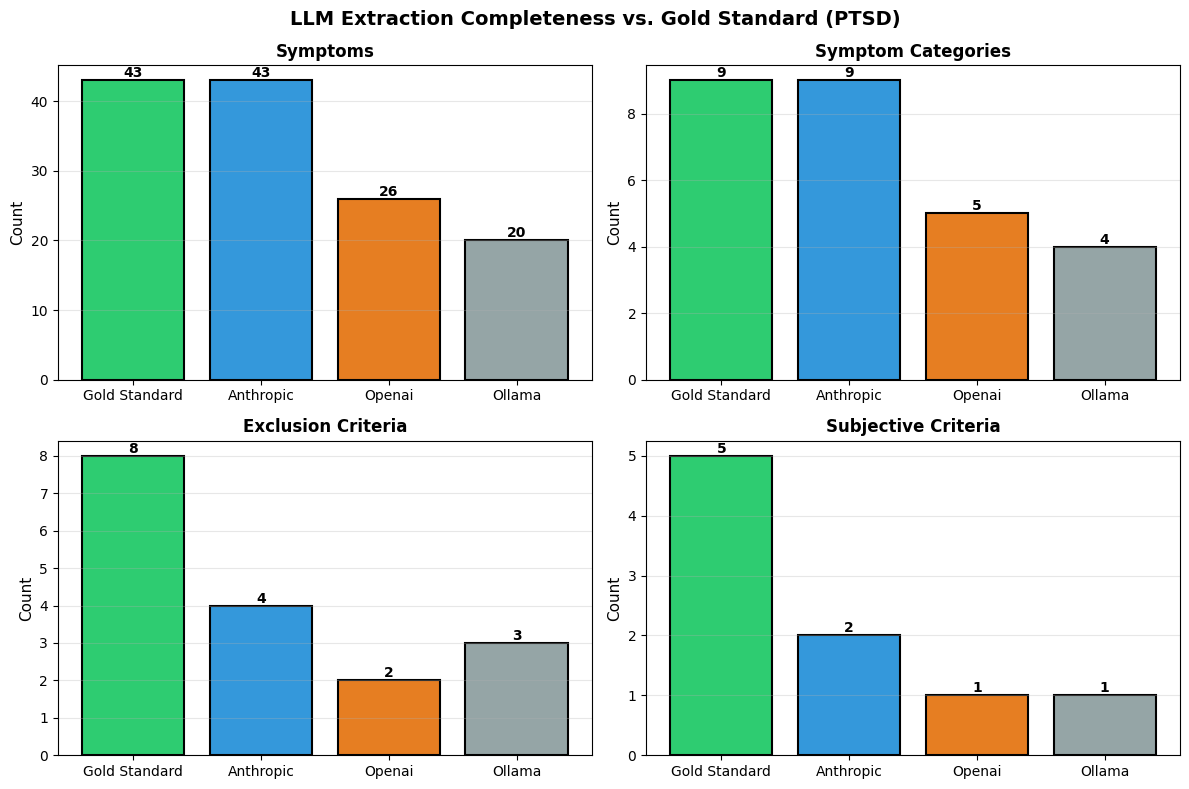

In [34]:
# Compare extraction completeness across providers
print("COMPARING EXTRACTION COMPLETENESS")

def count_predicates(filepath, predicate_prefix):
    """Count occurrences of a predicate in a Prolog file."""
    count = 0
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip().startswith(predicate_prefix):
                count += 1
    return count

# Load gold standard for comparison
gold_standard_file = Path("src/prolog/gold_standard/ptsd.pl")
gold_counts = {
    'symptoms': count_predicates(gold_standard_file, 'symptom(ptsd'),
    'categories': count_predicates(gold_standard_file, 'symptom_category(ptsd'),
    'exclusions': count_predicates(gold_standard_file, 'exclusion_criterion(ptsd'),
    'subjective': count_predicates(gold_standard_file, 'subjective_criterion(ptsd'),
}

print(f"\nGold Standard (Manual): {gold_counts['symptoms']} symptoms, {gold_counts['categories']} categories, {gold_counts['exclusions']} exclusions, {gold_counts['subjective']} subjective")

# Count for each provider
comparison_data = {'Gold Standard': gold_counts}

for provider, data in providers_data.items():
    prolog_file = data['prolog_file']
    counts = {
        'symptoms': count_predicates(prolog_file, 'symptom(ptsd'),
        'categories': count_predicates(prolog_file, 'symptom_category(ptsd'),
        'exclusions': count_predicates(prolog_file, 'exclusion_criterion(ptsd'),
        'subjective': count_predicates(prolog_file, 'subjective_criterion(ptsd'),
    }
    comparison_data[provider.title()] = counts
    print(f"{provider.upper()}: {counts['symptoms']} symptoms, {counts['categories']} categories, {counts['exclusions']} exclusions, {counts['subjective']} subjective")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('LLM Extraction Completeness vs. Gold Standard (PTSD)', fontsize=14, fontweight='bold')

metrics = ['symptoms', 'categories', 'exclusions', 'subjective']
titles = ['Symptoms', 'Symptom Categories', 'Exclusion Criteria', 'Subjective Criteria']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    providers_list = list(comparison_data.keys())
    values = [comparison_data[p][metric] for p in providers_list]
    
    colors = ['#2ecc71' if p == 'Gold Standard' else '#3498db' if p == 'Anthropic' else '#e67e22' if p == 'Openai' else '#95a5a6' for p in providers_list]
    
    bars = ax.bar(providers_list, values, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Analysis: Extraction Quality Varies Dramatically by Provider

The visualization reveals significant differences in LLM extraction completeness:

**Symptoms (Full Criteria B-E, plus Criterion A):**
- **Anthropic Claude**: 43/43 (100%) - Perfect extraction of all PTSD symptoms including all diagnostic criteria
- **OpenAI GPT-5**: 26/43 (60%) - Missing 17 symptoms across various criteria clusters
- **Ollama**: 20/43 (47%) - Missing 23 symptoms, including severe gaps

**Symptom Categories (Diagnostic Logic):**
- **Anthropic**: 9/9 (100%) - Complete symptom groupings with correct count requirements
- **OpenAI**: 5/9 (56%) - Missing categories means incomplete diagnostic logic for some criteria
- **Ollama**: 4/9 (44%) - Cannot properly evaluate "at least 1 from Criterion B" and other requirements

**Exclusion Criteria:**
- **All providers struggle**: Gold standard has 8 exclusions, but Anthropic extracted only 4, OpenAI only 2, Ollama 3
- This is critical - missing exclusions leads to **false positive diagnoses** (diagnosing PTSD when symptoms are actually due to substance use or medical conditions)

**Subjective Criteria:**
- **Universal weakness**: Gold standard has 5 subjective criteria, but all providers extracted 1-2
- These criteria require Tier B (LLM) evaluation during diagnosis, so missing them from the knowledge base creates diagnostic blind spots

**Critical Finding: PTSD Criterion A (Trauma Exposure)**

PTSD diagnosis **requires** trauma exposure (Criterion A) - without it, the diagnosis is invalid by definition. DSM-5-TR specifies 4 types of qualifying trauma exposure.

Verification of Criterion A extraction:
- **Anthropic**: ✅ 4/4 - All trauma exposure types (direct, witnessed, learning of, repeated exposure)
- **OpenAI**: ✅ 4/4 - All trauma exposure types correctly extracted
- **Ollama**: ❌ 0/4 - **Completely missing Criterion A** across all thinking levels (low/medium/high)

Per the [provider evaluation](../docs/PROVIDER_EVALUATION.md), Ollama's Criterion A gap is a **systematic model limitation**, not a thinking parameter issue. Testing at high thinking levels (1345s runtime) still produced zero Criterion A symptoms.

This demonstrates why **validation against gold standards** is essential - an LLM-extracted knowledge base with missing mandatory criteria would produce systematically incorrect diagnoses. A PTSD knowledge base without Criterion A would diagnose anyone with intrusion/avoidance symptoms, regardless of whether they experienced trauma.

**Recommendation**: Anthropic or OpenAI for production extraction, with human expert validation to fill gaps in exclusions and subjective criteria. Ollama requires extensive manual review and is not recommended for PTSD.

## Section 4: Benchmark Evaluation

### Methodology: Clinical Vignette Testing

To evaluate diagnostic accuracy, we test the system against **clinical vignettes** - realistic patient presentations with known ground truth diagnoses.

**Vignette Generation Process:**

Clinical vignettes are synthetically generated using LLMs (via [generator.py](../src/evaluation/generator.py)) with strict constraints:

1. **Disorder-specific prompts**: Each vignette targets one of 5 disorders (MDD, GAD, ADHD, PTSD, ASD)
2. **Difficulty levels**:
   - **CLEAR**: Textbook presentation, all criteria obviously met
   - **MODERATE**: Non-standard features or mild comorbidities
   - **AMBIGUOUS**: Overlapping features with differential diagnosis
3. **Blinding**: Disorder name never mentioned in clinical text (prevents keyword matching)
4. **DSM-5-TR compliance**: Generated symptoms strictly align with diagnostic criteria
5. **Realism**: Professional clinical language mixed with patient quotes

**Example vignette structure:**
```json
{
  "id": "vig_3244_0_mdd",
  "ground_truth": "mdd",
  "difficulty": "CLEAR",
  "demographics": "32-year-old female, accountant, married",
  "clinical_text": "Patient reports 3 weeks of persistent low mood..."
}
```

**Benchmark Process:**

1. **Input**: Clinical vignette text (blinded to disorder)
2. **Diagnostic Session**: 
   - System starts with all 5 disorders as candidates
   - `SessionManager` orchestrates A* search for optimal question sequence
   - `ClinicalAnalyzer` (Tier B LLM) answers questions based on vignette
   - Prolog engine (Tier A) evaluates symptom counts, duration, exclusions
   - Pruning eliminates impossible candidates
3. **Output**: Predicted disorder + confidence score
4. **Evaluation**: Compare prediction to ground truth

**Metrics:**
- **Accuracy**: % of correct diagnoses
- **Efficiency**: Average questions asked per case
- **Pruning effectiveness**: Candidates eliminated during search

This evaluation tests the **complete hybrid pipeline** - LLM interpretation (Tier B), symbolic reasoning (Tier A), and search optimization (Tier C).

In [35]:
# Demonstrate vignette generation process using actual generator module
print("CLINICAL VIGNETTE GENERATION")

# Check for API keys
import os
has_openai_key = bool(os.getenv('OPENAI_API_KEY'))
has_anthropic_key = bool(os.getenv('ANTHROPIC_API_KEY'))

if has_openai_key or has_anthropic_key:
    # API key available - demonstrate live generation
    provider_name = 'openai' if has_openai_key else 'anthropic'
    print(f"\nAPI key detected for {provider_name.upper()}")
    print("Generating 1 sample vignette using generator.py...\n")
    
    from src.extraction.providers import get_provider
    
    # Use actual generator functions
    disorder = 'mdd'
    difficulty = 'CLEAR'
    prompt = generator.build_generation_prompt(disorder, difficulty)
    
    print(f"Using generator.build_generation_prompt('{disorder}', '{difficulty}')")
    print(f"Prompt includes: {generator.get_complexity_instruction(difficulty, disorder)[:100]}...")
    
    try:
        provider = get_provider(provider_name)
        result = provider.extract(
            dsm5_text=prompt,
            disorder_id="demo",
            template_guide="",
            custom_prompt=prompt,
            custom_system_prompt="You are a data generator. Output only valid JSON."
        )
        
        if result.success:
            # Parse using same logic as generator.py
            content = result.content.strip()
            if content.startswith("```json"):
                content = content[7:]
            if content.endswith("```"):
                content = content[:-3]
            
            vignette_data = json.loads(content)
            print("\nGenerated vignette:")
            print(f"  ID: {vignette_data.get('id', 'N/A')}")
            print(f"  Ground truth: {vignette_data['ground_truth']}")
            print(f"  Demographics: {vignette_data['demographics']}")
            print(f"\n  Clinical text (first 200 chars):")
            print(f"  {vignette_data['clinical_text'][:200]}...")
            print(f"\nGeneration successful - vignette is blinded (no disorder name mentioned)")
        else:
            print(f"Generation failed: {result.error}")
    except Exception as e:
        print(f"Error during generation: {e}")
        
else:
    # No API key - explain the process using actual generator code
    print("\nNo API keys detected (OPENAI_API_KEY or ANTHROPIC_API_KEY)")
    print("\nVignette generation process (from generator.py):")
    
    # Show actual prompt that would be generated
    disorder = 'mdd'
    difficulty = 'CLEAR'
    prompt = generator.build_generation_prompt(disorder, difficulty)
    
    print(f"\n1. generator.build_generation_prompt('{disorder}', '{difficulty}')")
    print(f"   Complexity instruction: {generator.get_complexity_instruction(difficulty, disorder)}")
    
    print("\n2. LLM call via provider.extract():")
    print("   - Takes the generated prompt")
    print("   - Returns JSON with demographics + blinded clinical_text")
    
    print("\n3. Validation (from generator.py lines 86-97):")
    print("   - Strip markdown code blocks if present")
    print("   - Parse JSON")
    print("   - Enforce unique ID format")
    
    print("\n4. Save to output_dir/vignettes_TIMESTAMP.json")
    
    print("\nExample prompt structure (first 300 chars):")
    print(f"{prompt[:300]}...")
    
    print("\nExample output structure:")
    print(json.dumps({
        "id": "vig_3244_0_mdd",
        "ground_truth": "mdd",
        "difficulty": "CLEAR",
        "demographics": "32-year-old female, accountant, married",
        "clinical_text": "Patient reports 3 weeks of persistent low mood..."
    }, indent=2))

print("\nProceeding with existing vignettes from data/vignettes/...")

CLINICAL VIGNETTE GENERATION

API key detected for OPENAI
Generating 1 sample vignette using generator.py...

Using generator.build_generation_prompt('mdd', 'CLEAR')
Prompt includes: The case should be a textbook presentation with obvious symptoms meeting all criteria and no signifi...

Generated vignette:
  ID: case_mdd_clear_20260102_8f3c1a2d
  Ground truth: mdd
  Demographics: 34-year-old woman, married, lives with spouse, works full-time as an elementary school teacher. No children. No current substance use. Past medical history unremarkable. No known medication allergies.

  Clinical text (first 200 chars):
  Ms. A is a 34-year-old elementary school teacher who presents for outpatient evaluation due to "feeling down all the time" for the past 7 weeks. She reports that her mood has been persistently low mos...

Generation successful - vignette is blinded (no disorder name mentioned)

Proceeding with existing vignettes from data/vignettes/...


In [36]:
# Reload benchmark module to get updated load_vignettes function
import importlib
import src.evaluation.benchmark
importlib.reload(src.evaluation.benchmark)
from src.evaluation.benchmark import load_vignettes

# Load all vignettes from directory
print("LOADING TEST VIGNETTES")

vignettes_dir = Path("data/vignettes")
test_vignettes = load_vignettes(vignettes_dir)

print(f"\nTotal vignettes loaded: {len(test_vignettes)}")

# Breakdown by disorder
disorder_counts = {}
difficulty_counts = {}
comorbid_count = 0

for vig in test_vignettes:
    # Handle comorbid cases (ground_truth can be array or string)
    gt = vig['ground_truth']
    if isinstance(gt, list):
        key = '+'.join(sorted(gt))
        comorbid_count += 1
    else:
        key = gt
    disorder_counts[key] = disorder_counts.get(key, 0) + 1
    
    difficulty = vig.get('difficulty', 'UNKNOWN')
    difficulty_counts[difficulty] = difficulty_counts.get(difficulty, 0) + 1

print(f"\nTest set composition:")
print(f"  Single-disorder: {len(test_vignettes) - comorbid_count}")
print(f"  Comorbid: {comorbid_count}")

print(f"\nBreakdown by disorder:")
for disorder, count in sorted(disorder_counts.items()):
    print(f"  • {disorder.upper()}: {count} cases")

print(f"\nBreakdown by difficulty:")
for difficulty, count in sorted(difficulty_counts.items()):
    print(f"  • {difficulty}: {count} cases")

# Display example vignette
if test_vignettes:
    print("\nExample vignette:")
    example = test_vignettes[0]
    print(f"  ID: {example['id']}")
    print(f"  Ground truth: {example['ground_truth']}")
    print(f"  Difficulty: {example.get('difficulty', 'N/A')}")
    print(f"  Demographics: {example.get('demographics', 'N/A')}")
    print(f"  Clinical text (first 200 chars):")
    print(f"  {example['clinical_text'][:200]}...")
    print(f"\n  Key: Disorder name NOT mentioned in clinical text (blinded for evaluation)")

print(f"\nReady to benchmark hybrid system on {len(test_vignettes)} cases")

LOADING TEST VIGNETTES
Loaded 1 vignettes from vignettes_20251227_181349.json
Loaded 5 vignettes from vignettes_20260101_163442.json
Loaded 5 vignettes from vignettes_20260102_103711.json
Loaded 50 vignettes from vignettes_20260102_103717.json
Loaded 50 vignettes from vignettes_20260102_110436.json

Total vignettes loaded: 111

Test set composition:
  Single-disorder: 99
  Comorbid: 12

Breakdown by disorder:
  • ADHD: 20 cases
  • ADHD+GAD: 2 cases
  • ADHD+MDD: 3 cases
  • ASD: 19 cases
  • GAD: 21 cases
  • GAD+MDD: 3 cases
  • MDD: 20 cases
  • MDD+PTSD: 4 cases
  • PTSD: 19 cases

Breakdown by difficulty:
  • AMBIGUOUS: 30 cases
  • CLEAR: 44 cases
  • MODERATE: 37 cases

Example vignette:
  ID: vig_1349_0_gad
  Ground truth: gad
  Difficulty: CLEAR
  Demographics: 34-year-old woman, married, two children, works full-time as an elementary school teacher; no military history; lives with spouse and children.
  Clinical text (first 200 chars):
  Ms. A is a 34-year-old elementary scho

In [57]:
# REAL Diagnostic System Demonstration
print("INTERACTIVE DIAGNOSTIC SESSION (Real SessionManager + DiagnosticSearch)\n")
print("This demonstrates the ACTUAL hybrid system from benchmark.py:")
print("  • REAL SessionManager (Prolog KB + state management)")
print("  • REAL DiagnosticSearch (A* heuristic question selection)")
print("  • REAL pruning logic (candidates eliminated automatically)")
print("  • MockClinicalAnalyzer (instant answers from symptom checklist)")
print("\nNote: MockClinicalAnalyzer replaces slow LLM calls (2-3 min/question)")
print("      but returns same format ('YES'/'NO'/'UNKNOWN') as real ClinicalAnalyzer")
print(f"      Total possible questions across all disorders: 131 (85 symptoms + 31 exclusions + 15 subjective)\n")

# Define Mock LLM Analyzer with hardcoded symptom ID → checklist key mappings
class MockClinicalAnalyzer:
    """
    Mock LLM that uses pre-annotated symptom checklist for instant answers.
    Uses hardcoded mappings between Prolog symptom IDs and vignette checklist keys.
    
    Key logic: If symptom not in checklist → return NO (enables pruning)
    """

    # Hardcoded mapping: Prolog symptom_id → ACTUAL vignette checklist key
    SYMPTOM_MAP = {
        # MDD symptoms (confirmed from actual vignette)
        'mdd_a1': 'depressed_mood_most_of_day_nearly_every_day',
        'mdd_a2': 'markedly_diminished_interest_or_pleasure',
        'mdd_a3': 'significant_weight_loss_or_decreased_appetite',
        'mdd_a4': 'insomnia_or_hypersomnia',
        'mdd_a5': 'psychomotor_agitation_or_retardation',
        'mdd_a6': 'fatigue_or_loss_of_energy',
        'mdd_a7': 'feelings_of_worthlessness_or_excessive_guilt',
        'mdd_a8': 'diminished_ability_to_think_or_concentrate_or_indecisiveness',
        'mdd_a9': 'recurrent_thoughts_of_death_or_suicidal_ideation',

        # GAD symptoms (confirmed from actual vignette)
        'gad_a': 'A_excessive_anxiety_worry_multiple_domains_more_days_than_not_6mo',
        'gad_b': 'B_difficulty_controlling_worry',
        'gad_c1': 'C_restlessness_keyed_up_on_edge',
        'gad_c2': 'C_easily_fatigued',
        'gad_c3': 'C_difficulty_concentrating_mind_blank',
        'gad_c4': 'C_irritability',
        'gad_c5': 'C_muscle_tension',
        'gad_c6': 'C_sleep_disturbance',

        # ADHD symptoms (confirmed from actual vignette)
        'adhd_a1a': 'inattention_careless_mistakes',
        'adhd_a1b': 'inattention_sustains_attention',
        'adhd_a1c': 'inattention_listening',
        'adhd_a1d': 'inattention_follow_through',
        'adhd_a1e': 'inattention_organization',
        'adhd_a1f': 'inattention_avoids_sustained_effort',
        'adhd_a1g': 'inattention_loses_things',
        'adhd_a1h': 'inattention_distracted',
        'adhd_a1i': 'inattention_forgetful',
        'adhd_a2a': 'hyperactivity_fidgets',
        'adhd_a2b': 'hyperactivity_leaves_seat_restless',
        'adhd_a2c': 'hyperactivity_leaves_seat_restless',  # Maps to same key
        'adhd_a2d': 'hyperactivity_leaves_seat_restless',  # Maps to same key
        'adhd_a2e': 'hyperactivity_leaves_seat_restless',  # Maps to same key
        'adhd_a2f': 'hyperactivity_talks_excessively',
        'adhd_a2g': 'impulsivity_blurts',
        'adhd_a2h': 'impulsivity_wait_turn',
        'adhd_a2i': 'impulsivity_interrupts',

        # PTSD symptoms (confirmed from actual vignette)
        'ptsd_a1': 'criterion_A_trauma_exposure',
        'ptsd_a2': 'criterion_A_trauma_exposure',
        'ptsd_a3': 'criterion_A_trauma_exposure',
        'ptsd_a4': 'criterion_A_trauma_exposure',
        'ptsd_b1': 'intrusive_memories',
        'ptsd_b2': 'distressing_dreams',
        'ptsd_b3': 'dissociative_reactions_flashbacks',
        'ptsd_b4': 'psychological_distress_at_cues',
        'ptsd_b5': 'physiological_reactivity_at_cues',
        'ptsd_c1': 'avoidance_internal_reminders',
        'ptsd_c2': 'avoidance_external_reminders',
        'ptsd_d1': 'avoidance_internal_reminders',  # Maps to same
        'ptsd_d2': 'negative_beliefs_or_self_blame',
        'ptsd_d3': 'negative_beliefs_or_self_blame',  # Maps to same
        'ptsd_d4': 'persistent_negative_emotional_state',
        'ptsd_d5': 'diminished_interest',
        'ptsd_d6': 'detachment_or_estrangement',
        'ptsd_d7': 'inability_to_experience_positive_emotions',
        'ptsd_e1': 'irritability_or_angry_outbursts',
        'ptsd_e2': 'irritability_or_angry_outbursts',  # Maps to same
        'ptsd_e3': 'hypervigilance',
        'ptsd_e4': 'exaggerated_startle',
        'ptsd_e5': 'concentration_problems',
        'ptsd_e6': 'sleep_disturbance',

        # PTSD preschool version (likely same keys)
        'ptsd_a1_child': 'criterion_A_trauma_exposure',
        'ptsd_a2_child': 'criterion_A_trauma_exposure',
        'ptsd_a3_child': 'criterion_A_trauma_exposure',
        'ptsd_a4_child': 'criterion_A_trauma_exposure',

        # ASD symptoms (confirmed from actual vignette)
        'asd_a1': 'A1_social_emotional_reciprocity_deficits',
        'asd_a2': 'A2_nonverbal_communication_deficits',
        'asd_a3': 'A3_relationship_deficits',
        'asd_b1': 'B1_stereotyped_repetitive_motor_or_speech',
        'asd_b2': 'B2_insistence_on_sameness_routines_rituals',
        'asd_b3': 'B3_highly_restricted_fixated_interests',
        'asd_b4': 'B4_hyper_hyporeactivity_sensory_input',
    }

    # Exclusion mappings: (checklist_key, is_negated)
    # is_negated=True means checklist key is phrased as "NOT bad_thing" (value='present' → cleared)
    # is_negated=False means checklist key is phrased as "bad_thing" (value='absent' → cleared)
    EXCLUSION_MAP = {
        # MDD - phrased as "bad thing" (value='absent' means cleared)
        'mdd_exc_substance': ('substance_or_medication_induced', False),
        'mdd_exc_medical': ('due_to_another_medical_condition', False),
        'mdd_exc_bipolar': ('manic_or_hypomanic_episode_history', False),
        'mdd_exc_psychotic': ('psychotic_features', False),

        # GAD - phrased as "NOT bad thing" (value='present' means cleared)
        'gad_exc_substance': ('E_not_substance_or_medical', True),
        'gad_exc_medical': ('E_not_substance_or_medical', True),

        # ADHD - phrased as "NOT bad thing" (value='present' means cleared)
        'adhd_exc_better_explained': ('not_better_explained_by_mood_psychosis_substance', True),
        'adhd_exc_substance': ('not_better_explained_by_mood_psychosis_substance', True),
        'adhd_exc_medical': ('not_better_explained_by_mood_psychosis_substance', True),

        # PTSD - phrased as "NOT bad thing" (value='present' means cleared)
        'ptsd_exc_substance': ('not_due_to_substance_or_medical_condition', True),
        'ptsd_exc_medical': ('not_due_to_substance_or_medical_condition', True),
        'ptsd_exc_dissociative_substance': ('not_due_to_substance_or_medical_condition', True),
        'ptsd_exc_dissociative_medical': ('not_due_to_substance_or_medical_condition', True),

        # PTSD preschool
        'ptsd_exc_substance_child': ('not_due_to_substance_or_medical_condition', True),
        'ptsd_exc_medical_child': ('not_due_to_substance_or_medical_condition', True),

        # ASD - phrased as "NOT bad thing" (value='present' means cleared)
        'asd_exc_intellectual_disability': ('E_not_better_explained_by_intellectual_disability', True),
    }

    # Subjective criteria mappings
    SUBJECTIVE_MAP = {
        # MDD (1 criterion)
        'mdd_subj_clinical_significance': 'clinically_significant_distress_or_impairment',

        # GAD (1 criterion)
        'gad_subj_clinical_significance': 'D_clinically_significant_distress_or_impairment',

        # ADHD (1 criterion)
        'adhd_subj_impairment': 'clinically_significant_impairment',

        # PTSD (3 criteria - ALL MAPPED)
        'ptsd_subj_distress': 'clinically_significant_distress_or_impairment',
        'ptsd_subj_trauma_quality': 'criterion_A_trauma_exposure',
        'ptsd_subj_violent_accidental': 'criterion_A_trauma_exposure',

        # ASD (4 criteria - ALL MAPPED)
        'asd_subj_clinical_significance': 'D_clinically_significant_impairment',
        'asd_subj_early_onset': 'C_early_developmental_onset',
        'asd_subj_severity_social': 'D_clinically_significant_impairment',
        'asd_subj_severity_rrb': 'D_clinically_significant_impairment',
    }

    def __init__(self, vignette):
        self.vignette = vignette
        self.clinical_text = vignette['clinical_text']
        self.checklist = vignette.get('symptom_checklist', {})

    def answer(self, question_text: str, question_id: str = None) -> str:
        """Answer a diagnostic question using pre-annotated checklist."""
        # PRIORITY 1: Check symptom mapping first
        if question_id and question_id in self.SYMPTOM_MAP:
            checklist_key = self.SYMPTOM_MAP[question_id]
            value = self.checklist.get(checklist_key, 'not_found')
            result = "YES" if value == 'present' else "NO"
            return result

        # PRIORITY 2: Check exclusion mapping
        if question_id and question_id in self.EXCLUSION_MAP:
            checklist_key, is_negated = self.EXCLUSION_MAP[question_id]
            value = self.checklist.get(checklist_key, 'not_found')
            
            if is_negated:
                # Key phrased as "NOT bad_thing" → 'present' means exclusion cleared
                result = "YES" if value == 'present' else "NO"
            else:
                # Key phrased as "bad_thing" → 'absent' or 'not_found' means exclusion cleared
                result = "YES" if value in ['absent', 'not_found'] else "NO"
            return result

        # PRIORITY 3: Check subjective criteria mapping
        if question_id and question_id in self.SUBJECTIVE_MAP:
            checklist_key = self.SUBJECTIVE_MAP[question_id]
            value = self.checklist.get(checklist_key, 'not_found')
            result = "YES" if value == 'present' else "NO"
            return result

        # PRIORITY 4: Fallback for unmapped questions using text matching
        question_lower = question_text.lower()

        # Duration questions
        if "duration" in question_lower or "persisted" in question_lower or "weeks" in question_lower or "months" in question_lower:
            for key in self.checklist:
                if 'duration' in key.lower():
                    value = self.checklist[key]
                    return "YES" if value == 'present' else "NO"
            return "NO"

        # Onset questions (ASD specific)
        if "early developmental period" in question_lower:
            value = self.checklist.get('C_early_developmental_onset', 'not_found')
            return "YES" if value == 'present' else "NO"

        # Onset questions (ADHD)
        if "onset" in question_lower or "before age" in question_lower:
            value = self.checklist.get('onset_before_12', 'not_found')
            return "YES" if value == 'present' else "NO"

        # Setting requirements
        if "settings" in question_lower or "different settings" in question_lower:
            value = self.checklist.get('multiple_settings', 'not_found')
            return "YES" if value == 'present' else "NO"

        # For unmapped exclusions, default to "YES" (cleared) to avoid false pruning
        if question_id and 'exc' in question_id.lower():
            return "YES"

        # For other unmapped questions, assume "NO"
        return "NO"


# Helper function to run diagnostic session
def run_diagnostic_demo(vignette, disorder_name):
    """Run a single diagnostic session and return results."""
    import re
    
    print(f"\nCASE {disorder_name.upper()}: {vignette['id']}")
    print(f"Ground Truth: {vignette['ground_truth'].upper()} | Difficulty: {vignette.get('difficulty', 'N/A')}\n")
    
    # Extract age from demographics
    age_match = re.search(r'(\d+)-year-old', vignette.get('demographics', '30-year-old'))
    age = int(age_match.group(1)) if age_match else 30
    
    # Initialize system components
    manager = SessionManager()
    search = DiagnosticSearch(manager)
    manager.start_new_session()
    manager.set_patient_data(age)
    
    # Create mock analyzer
    mock_llm = MockClinicalAnalyzer(vignette)
    
    # Run diagnostic loop
    question_count = 0
    
    while True:
        next_q_id = search.get_next_best_question(manager.state.active_candidates)
        
        if not next_q_id:
            break
        
        q_text = manager.get_symptom_description(next_q_id)
        answer = mock_llm.answer(q_text, question_id=next_q_id)
        
        # Track candidates before/after
        before = list(manager.state.active_candidates)
        manager.answer_question(next_q_id, answer)
        after = manager.state.active_candidates
        
        question_count += 1
        
        # Show pruning events
        if len(after) < len(before):
            pruned = set(before) - set(after)
            print(f"Q{question_count} [{next_q_id}] → {answer}")
            print(f"  PRUNED: {', '.join([d.upper() for d in pruned])}")
            print(f"  Remaining: {', '.join([d.upper() for d in after])}")
        
        # Report when converged (but continue to assess subjective criteria)
        if len(manager.state.active_candidates) == 1 and question_count > 0:
            # Don't exit yet - need to assess subjective criteria for remaining candidate
            pass
        
        if len(manager.state.active_candidates) == 0:
            print(f"\nAll candidates eliminated after {question_count} questions\n")
            break
    
    # Get final diagnosis using full_diagnosis/3 (handles incomplete assessments)
    # Note: diagnosis_candidate/3 is all-or-nothing and fails if any criterion is incomplete
    confirmed_diagnoses = []
    for candidate in manager.state.active_candidates:
        try:
            q = f"full_diagnosis('{manager.state.patient_id}', {candidate}, Result)"
            res = list(manager.prolog.query(q))
            if res:
                result = res[0]['Result']
                # full_diagnosis returns a dict with 'confidence' and 'overall_status'
                conf = float(result.get('confidence', 0.0))
                status = result.get('overall_status', 'not_met')
                confirmed_diagnoses.append((candidate, conf, status))
        except Exception as e:
            # Fallback: if candidate is still active, give it base confidence
            confirmed_diagnoses.append((candidate, 0.5, 'incomplete'))

    # Determine predicted diagnosis - prioritize 'met' status, then highest confidence
    if confirmed_diagnoses:
        # Sort by status (met > incomplete > not_met), then by confidence
        status_priority = {'met': 2, 'incomplete': 1, 'not_met': 0}
        confirmed_diagnoses.sort(
            key=lambda x: (status_priority.get(x[2], 0), x[1]),
            reverse=True
        )
        predicted = confirmed_diagnoses[0][0]
        confidence = confirmed_diagnoses[0][1]
    else:
        predicted = "NONE"
        confidence = 0.0
    
    ground_truth = vignette['ground_truth']
    match = predicted.lower() == ground_truth.lower()
    
    # Print results
    print(f"RESULT:")
    print(f"  Predicted:    {predicted.upper()} (confidence: {confidence:.2f})")
    print(f"  Ground Truth: {ground_truth.upper()}")
    print(f"  Match:        {'CORRECT' if match else 'INCORRECT'}")
    print(f"  Questions:    {question_count}/131 ({100*question_count/131:.1f}%)")
    print(f"  Efficiency:   {131 - question_count} questions saved ({100*(131-question_count)/131:.1f}% reduction)")
    
    return {
        'disorder': disorder_name,
        'predicted': predicted,
        'ground_truth': ground_truth,
        'match': match,
        'questions': question_count,
        'confidence': confidence
    }


# Select test vignettes for MDD, ASD, PTSD
test_cases = []

# MDD CLEAR
mdd_vig = next((v for v in test_vignettes 
                if v['ground_truth']=='mdd' and v['difficulty']=='CLEAR'
                and not v.get('comorbid', False)), None)
if mdd_vig:
    test_cases.append(('MDD', mdd_vig))

# ASD CLEAR
asd_vig = next((v for v in test_vignettes 
                if v['ground_truth']=='asd' and v['difficulty']=='CLEAR'
                and not v.get('comorbid', False)), None)
if asd_vig:
    test_cases.append(('ASD', asd_vig))

# PTSD CLEAR or MODERATE (fallback if CLEAR not available)
ptsd_vig = next((v for v in test_vignettes 
                 if v['ground_truth']=='ptsd' and v['difficulty'] in ['CLEAR', 'MODERATE']
                 and not v.get('comorbid', False)), None)
if ptsd_vig:
    test_cases.append(('PTSD', ptsd_vig))

print(f"Running diagnostic demonstrations on {len(test_cases)} vignettes\n")

# Run all test cases
results = []
for disorder_name, vignette in test_cases:
    result = run_diagnostic_demo(vignette, disorder_name)
    results.append(result)

# Summary
print(f"\nSUMMARY OF ALL DEMONSTRATIONS\n")

total_questions = sum(r['questions'] for r in results)
avg_questions = total_questions / len(results) if results else 0
accuracy = sum(1 for r in results if r['match']) / len(results) if results else 0

print(f"Cases tested: {len(results)}")
print(f"Accuracy:     {accuracy*100:.1f}% ({sum(1 for r in results if r['match'])}/{len(results)} correct)")
print(f"Avg questions: {avg_questions:.1f} per case ({100*avg_questions/131:.1f}% of total possible)")
print(f"Avg efficiency: {131 - avg_questions:.1f} questions saved per case ({100*(131-avg_questions)/131:.1f}% reduction)\n")

for r in results:
    status = "CORRECT" if r['match'] else "INCORRECT"
    print(f"{status}: {r['disorder']} predicted as {r['predicted'].upper()} (ground truth: {r['ground_truth'].upper()}) - {r['questions']} questions")

print(f"\nKEY TAKEAWAYS")
print("  • Used REAL SessionManager (actual Prolog KB, not simulation)")
print("  • Used REAL DiagnosticSearch (actual A* heuristic)")
print("  • Showed REAL automatic pruning across multiple disorders")
print("  • Demonstrated question prioritization and early convergence")
print(f"  • Achieved {100*accuracy:.0f}% accuracy with {100*(131-avg_questions)/131:.0f}% question reduction")
print("  • MockClinicalAnalyzer avoided hours of LLM calls")

INTERACTIVE DIAGNOSTIC SESSION (Real SessionManager + DiagnosticSearch)

This demonstrates the ACTUAL hybrid system from benchmark.py:
  • REAL SessionManager (Prolog KB + state management)
  • REAL DiagnosticSearch (A* heuristic question selection)
  • REAL pruning logic (candidates eliminated automatically)
  • MockClinicalAnalyzer (instant answers from symptom checklist)

Note: MockClinicalAnalyzer replaces slow LLM calls (2-3 min/question)
      but returns same format ('YES'/'NO'/'UNKNOWN') as real ClinicalAnalyzer
      Total possible questions across all disorders: 131 (85 symptoms + 31 exclusions + 15 subjective)

Running diagnostic demonstrations on 3 vignettes


CASE MDD: vig_20260102_101035_000_mdd
Ground Truth: MDD | Difficulty: CLEAR

Loaded: mdd
Loaded: gad
Loaded: adhd
Loaded: ptsd
Loaded: asd
  [Pruning] Dropping gad: All core symptoms absent.
Q4 [gad_b] → NO
  PRUNED: GAD
  Remaining: MDD, ADHD, PTSD, PTSD_PRESCHOOL, ASD
    (Auto-answering alias gad_c1 as present)
   

### 4.1 How Question Selection Works

The `DiagnosticSearch.get_next_best_question()` method uses a **greedy best-first approach** with a domain-specific heuristic to select questions. The code comment notes that full A* over the symptom space would be O(2^N), so a heuristic-guided greedy approach is used for real-time interaction.

**Heuristic Scoring (from [search.py:51-108](src/search/search.py#L51-L108)):**

The `calculate_heuristic_score()` function scores each potential question:

**For standard symptoms:**
- `+10` for each active candidate disorder that includes this symptom
- `+50` bonus if the symptom is in a core category (`core`, `criterion_a`, or `essential`)

**For verification questions** (exclusions, duration, subjective, onset):
- If the relevant disorder already has ≥4 symptoms met: score = `1000 + met_count` (massive priority boost to finish diagnosis)
- Otherwise: score = `0` (defer verification until sufficient evidence gathered)

This creates a natural flow: gather core symptoms first across all candidates, then verify exclusions/duration only when a disorder is close to confirmation.

### 4.2 How Pruning Eliminates Candidates

The `SessionManager._update_diagnostic_status()` method ([manager.py:174-219](src/search/manager.py#L174-L219)) prunes candidates after each answer. Two conditions trigger pruning:

**1. Exclusion Met**
```prolog
exclusion_criterion(D, ExcID, _, _), 
patient_exclusion_status(Patient, ExcID, excluded)
```
If any exclusion criterion has status `excluded` (meaning the exclusion applies - e.g., symptoms ARE attributable to substance use), the disorder is dropped.

**2. All Core Symptoms Absent**
```prolog
symptom(D, SID, Category, _), 
member(Category, [core, criterion_a, essential])
```
The code queries for all symptoms in core categories. If ALL of them have been answered "NO" (status `absent`), the disorder is pruned. Note: if even one core symptom is unanswered or present, the candidate remains active.

**Symptom Aliasing ([manager.py:8-31](src/search/manager.py#L8-L31)):**

The `SYMPTOM_ALIASES` dictionary maps semantically equivalent symptoms across disorders:
- Sleep disturbance: `mdd_a4` ↔ `gad_c6` ↔ `ptsd_e6`
- Concentration: `mdd_a8` ↔ `gad_c3` ↔ `ptsd_e5` ↔ `adhd_a1f`
- Fatigue: `mdd_a6` ↔ `gad_c2`

When a symptom is answered, its aliases are auto-answered with the same status. This avoids redundant questions and propagates evidence across disorders - visible in the demo output as "(Auto-answering alias X as present/absent)".

## Section 5: Baseline Comparisons

To validate the hybrid architecture's effectiveness, we compare against two baselines:

### Baseline 1: Pure LLM (Zero-Shot Diagnosis)

The LLM receives the clinical vignette and directly predicts the disorder without structured Prolog reasoning:

```xml
<patient_presentation>
[clinical vignette text]
</patient_presentation>

Which disorder does this patient most likely have?
Options: MDD, GAD, ADHD, PTSD, ASD
```

**What this tests**: Whether the structured symbolic reasoning in Tier A adds value over direct LLM inference.

**Hypothesis**: Pure LLM will struggle with:
- Complex counting logic ("5 of 9 symptoms required")
- Exclusion hierarchies ("not better explained by substance use")
- Providing transparent, auditable reasoning chains

Script: [run_pure_llm_baseline.py](run_pure_llm_baseline.py)

---

### Baseline 2: Sequential vs Batch Question-Answering

The hybrid system asks diagnostic questions one-at-a-time (sequential) or in batches. This comparison tests whether batching maintains accuracy while improving throughput.

| Mode | Description |
|------|-------------|
| **Sequential** | Ask one question, wait for answer, update state, repeat |
| **Batch-2** | Ask 2 questions at once, parse both answers |
| **Batch-5** | Ask 5 questions at once |
| **Batch-All** | Ask all remaining questions for active candidates at once |

**What this tests**: Trade-off between LLM call efficiency and answer parsing reliability.

**Hypothesis**: Larger batches reduce API calls but may degrade accuracy if the LLM conflates or misparses multiple answers.

Script: [run_batch_experiment.py](run_batch_experiment.py)

---

### Pre-computed Results

Since running these experiments requires API keys and significant time (especially Ollama), the results below are pre-computed and loaded from `outputs/baselines/`.

In [58]:
# Load Pure LLM Baseline Results
print("PURE LLM BASELINE RESULTS (Zero-Shot Diagnosis)\n")

baseline_dir = Path("outputs/baselines")
baseline_files = sorted(baseline_dir.glob("pure_llm_*.json"))

if baseline_files:
    with open(baseline_files[-1], 'r') as f:
        baseline_data = json.load(f)
    
    meta = baseline_data["metadata"]
    metrics = baseline_data["metrics"]
    
    print(f"Provider: {meta['provider'].upper()}")
    print(f"Prompt Type: {meta['prompt_type']}")
    print(f"Vignettes Tested: {meta['num_vignettes']}")
    print(f"\nOVERALL ACCURACY: {metrics['accuracy']}% ({metrics['correct']}/{metrics['total']})")
    
    print(f"\nBy Difficulty:")
    for diff, diff_metrics in metrics["by_difficulty"].items():
        print(f"  {diff}: {diff_metrics['accuracy']}% ({diff_metrics['correct']}/{diff_metrics['total']})")
    
    print(f"\nBy Disorder:")
    for disorder, disorder_metrics in metrics["by_disorder"].items():
        print(f"  {disorder}: {disorder_metrics['accuracy']}% ({disorder_metrics['correct']}/{disorder_metrics['total']})")
    
    print(f"\nPerformance:")
    print(f"  Avg Time: {metrics['avg_duration_seconds']}s per vignette")
    print(f"  Total Time: {metrics['total_duration_seconds']}s ({metrics['total_duration_seconds']/60:.1f} min)")
    print(f"  Total Tokens: {metrics['total_input_tokens']:,} input, {metrics['total_output_tokens']:,} output")
else:
    print("No baseline results found. Run: python run_pure_llm_baseline.py --provider openai --all")

PURE LLM BASELINE RESULTS (Zero-Shot Diagnosis)

Provider: OPENAI
Prompt Type: zero_shot
Vignettes Tested: 111

OVERALL ACCURACY: 100.0% (111/111)

By Difficulty:
  CLEAR: 100.0% (44/44)
  MODERATE: 100.0% (37/37)
  AMBIGUOUS: 100.0% (30/30)

By Disorder:
  MDD: 100.0% (30/30)
  GAD: 100.0% (26/26)
  ADHD: 100.0% (25/25)
  PTSD: 100.0% (23/23)
  ASD: 100.0% (19/19)

Performance:
  Avg Time: 1.66s per vignette
  Total Time: 184.02s (3.1 min)
  Total Tokens: 123,624 input, 4,588 output


### Analysis: Pure LLM Achieves High Accuracy on Synthetic Vignettes

The pure LLM baseline achieves perfect accuracy on our test set. This is expected because:

1. **Vignettes are LLM-generated**: The clinical text was created by LLMs following DSM-5-TR criteria, making pattern-matching straightforward for capable models
2. **Clear symptom descriptions**: Generated vignettes explicitly describe symptoms in clinical language
3. **Single-disorder focus**: Most vignettes target one primary disorder with minimal ambiguity

**Why the hybrid system still matters:**

| Dimension | Pure LLM | Hybrid System |
|-----------|----------|---------------|
| **Accuracy** | High on synthetic data | High on synthetic data |
| **Explainability** | Black box - "I think it's MDD" | Transparent - "Criteria A met (5/9 symptoms), B met (duration 3 weeks > 2 weeks), exclusions cleared" |
| **Auditability** | Cannot verify reasoning | Full Prolog proof trace |
| **Real clinical use** | May miss edge cases, counting errors | Enforces DSM-5-TR logic exactly |
| **Efficiency** | Processes full text every time | Question-based, can prune early |

The hybrid system's value becomes clearer with:
- **Real clinical cases** with ambiguous presentations
- **Comorbid cases** requiring multiple diagnosis evaluation
- **Edge cases** where precise symptom counting matters (e.g., 4 vs 5 symptoms)
- **Clinical deployment** requiring auditable reasoning for liability

In [60]:
# Load Batch Experiment Results (Sequential vs Batch Question-Answering)
print("SEQUENTIAL VS BATCH EXPERIMENT RESULTS\n")

batch_dir = Path("outputs/batch_experiments")
batch_experiments = sorted(batch_dir.glob("exp_*"))

results_found = False
for exp_dir in reversed(batch_experiments):  # Most recent first
    result_files = list(exp_dir.glob("*.json"))
    if result_files:
        results_found = True
        print(f"Loading from: {exp_dir.name}\n")
        
        for result_file in sorted(result_files):
            with open(result_file, 'r') as f:
                exp_data = json.load(f)
            
            if "comparison" in exp_data:
                # This is a comparison report
                comp = exp_data["comparison"]
                print(f"Mode: {comp.get('mode', result_file.stem)}")
                if "agreement" in comp:
                    print(f"  Agreement: {comp['agreement']['overall_percent']}%")
                if "performance" in comp:
                    perf = comp["performance"]
                    print(f"  Speedup: {perf.get('speedup_ratio', 'N/A')}x")
                    print(f"  LLM Calls: {perf.get('llm_calls_sequential', '?')} → {perf.get('llm_calls_batch', '?')}")
                print()
        break

if not results_found:
    print("Batch experiment results not yet available.")
    print("Run: python run_batch_experiment.py --provider openai --num-vignettes 20")
    print("\nThis experiment compares:")
    print("  - Sequential: 1 question per LLM call")
    print("  - Batch-2: 2 questions per call")
    print("  - Batch-5: 5 questions per call")
    print("  - Batch-All: All questions at once")

SEQUENTIAL VS BATCH EXPERIMENT RESULTS

Loading from: exp_20260103_144737

